In [6]:
import obonet
import pandas as pd
import os
import logging
import re
import numpy as np
from tqdm import tqdm
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from protnote.utils.configs import load_config

# Load the configuration and project root
config, project_root = load_config()
results_dir = config["paths"]["output_paths"]["RESULTS_DIR"]
logging.basicConfig(level=logging.INFO)


def calculate_label(row):
    """
    Helper function to calculate the label for a given row.
    Returns the definition of the row with any text between brackets removed.
    """
    definition = row.get("def", None)

    # Remove any text between brackets, e.g., PubMed citations
    # Remove leading and trailing quotation marks
    if definition is not None:
        definition = re.sub(r'\s*\[.*?\]\s*', '', definition)
        definition = definition.strip('"')
        
    return definition

def process_synonyms(row)->dict:
    """extracts the synonyms of a GO Annotation

    :param row: Row of GO annotation dataset
    :type row: _type_
    :return: dict
    :rtype: lists of synonyms for relevant scopes
    """    
    if row is np.nan or not row:
        return {"synonym_exact": [], "synonym_narrow": [], "synonym_related": [], "synonym_broad": []}

    scopes = {"EXACT": [], "NARROW": [], "RELATED": [], "BROAD": []}
    for synonym in row:
        match = re.search(r'\"(.+?)\"\s+(EXACT|NARROW|RELATED|BROAD)\s+\[', synonym)
        if match:
            text, scope = match.groups()
            scopes[scope].append(text)

    return {
        "synonym_exact": scopes["EXACT"],
        "synonym_narrow": scopes["NARROW"],
        "synonym_related": scopes["RELATED"],
        "synonym_broad": scopes["BROAD"]
    }


def download_and_process_obo(url: str):
    """
    Download the OBO file from the specified URL and save the GO ID and label to a pickle.
    """
    logging.info("Downloading and processing OBO file...")

    # Load the .obo file directly from the URL into a networkx graph using obonet
    os.makedirs('tmp', exist_ok=True)
    date = re.search(r"\d{4}-\d{2}-\d{2}", url).group()
    file = os.path.join('tmp', f"go_{date}.obo")
    
    if not os.path.exists(file):
        os.system(f"wget {url} -O {file} -q")

    graph = obonet.read_obo(file, ignore_obsolete=False)

    # Convert the graph nodes (terms) into a pandas dataframe
    df = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index')

    logging.info("Calculating labels...")
    # Create a new column called "label"
    df["label"] = df.apply(calculate_label, axis=1)

    # Filter the dataframe to retain only 'label', 'name' and 'synonym' columns, with the 'id' column as the index
    df_filtered = df[['label','name']+['is_obsolete']]

    obsolete_labels = set(df_filtered[df_filtered['is_obsolete']=="true"].index)
    used_labels = set(df_filtered.index) - obsolete_labels
    return used_labels,obsolete_labels

In [2]:

with open('Gene Ontology Data Archive.html','r') as handle:
    soup = BeautifulSoup(handle,'html.parser')

#Get all dates from releases during the last 10 years
dates=list(
    filter(lambda date: pd.to_datetime(date,format='%Y-%m-%d')>=pd.to_datetime('2014-06-01'),
        map(
            lambda x: x.get_text()[:-1],
            soup.findAll(lambda tag: tag.name =='a' and 'data-prefix' in tag.attrs)
            )
        )
    )

urls = [f'http://release.geneontology.org/{date}/ontology/go.obo' for date in dates]


prev_used_labels,prev_obsolete_labels = set(),set()

data = {'dates':[],'new_labels':[],'obsolete_labels':[],'used_labels':[]}


In [7]:

for date,url in tqdm(zip(dates,urls),total=len(urls)):
    used_labels,obsolete_labels = download_and_process_obo(url)
    print(url)
    data['dates'].append(date)

    new_labels = len(used_labels-prev_used_labels)
    obsolete_labels.update(prev_used_labels-used_labels) #augment obslete with other labels that simply don't show up
    new_obsolete_labels = len((obsolete_labels-prev_obsolete_labels))

    data['new_labels'].append(new_labels)
    data['obsolete_labels'].append(new_obsolete_labels)
    data['used_labels'].append(len(used_labels))


    print('new labels = ',new_labels)
    print('new obsolete = ',new_obsolete_labels)
    print('all labels = ',len(used_labels))

    prev_used_labels.update(used_labels)
    prev_obsolete_labels.update(obsolete_labels)


  0%|          | 0/113 [00:00<?, ?it/s]INFO:root:Downloading and processing OBO file...
INFO:root:Calculating labels...
  1%|          | 1/113 [00:06<11:22,  6.09s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2024-04-24/ontology/go.obo
new labels =  0
new obsolete =  497
all labels =  42255


INFO:root:Calculating labels...
  2%|▏         | 2/113 [00:12<11:32,  6.24s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2024-04-18/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  42271


INFO:root:Calculating labels...
  3%|▎         | 3/113 [00:18<11:24,  6.22s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2024-03-28/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  42312


INFO:root:Calculating labels...
  4%|▎         | 4/113 [00:24<11:16,  6.20s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2024-01-17/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  42442


INFO:root:Calculating labels...
  4%|▍         | 5/113 [00:30<10:53,  6.05s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-11-15/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  42769


INFO:root:Calculating labels...
  5%|▌         | 6/113 [00:36<10:55,  6.12s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-10-09/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  42837


INFO:root:Calculating labels...
  6%|▌         | 7/113 [00:42<10:48,  6.12s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-07-27/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  42887


INFO:root:Calculating labels...
  7%|▋         | 8/113 [00:49<10:41,  6.11s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-06-11/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  42950


INFO:root:Calculating labels...
  8%|▊         | 9/113 [00:55<10:36,  6.12s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-05-10/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43008


INFO:root:Calculating labels...
  9%|▉         | 10/113 [01:01<10:27,  6.09s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-04-01/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43093


INFO:root:Calculating labels...
 10%|▉         | 11/113 [01:07<10:26,  6.14s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-03-06/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43096


INFO:root:Calculating labels...
 11%|█         | 12/113 [01:13<10:09,  6.03s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2023-01-01/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43248


INFO:root:Calculating labels...
 12%|█▏        | 13/113 [01:19<10:06,  6.07s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-12-04/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43272


INFO:root:Calculating labels...
 12%|█▏        | 14/113 [01:25<09:59,  6.06s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-11-03/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43303


INFO:root:Calculating labels...
 13%|█▎        | 15/113 [01:31<09:51,  6.04s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-10-07/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43329


INFO:root:Calculating labels...
 14%|█▍        | 16/113 [01:37<09:44,  6.02s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-09-19/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43335


INFO:root:Calculating labels...
 15%|█▌        | 17/113 [01:43<09:43,  6.07s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-07-01/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43558


INFO:root:Calculating labels...
 16%|█▌        | 18/113 [01:49<09:36,  6.07s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-06-15/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43613


INFO:root:Calculating labels...
 17%|█▋        | 19/113 [01:55<09:30,  6.07s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-05-16/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43648


INFO:root:Calculating labels...
 18%|█▊        | 20/113 [02:01<09:23,  6.06s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-03-22/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43699


INFO:root:Calculating labels...
 19%|█▊        | 21/113 [02:07<09:16,  6.05s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-03-10/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43704


INFO:root:Calculating labels...
 19%|█▉        | 22/113 [02:13<09:02,  5.96s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2022-01-13/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43786


INFO:root:Calculating labels...
 20%|██        | 23/113 [02:19<09:02,  6.03s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-12-15/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43789


INFO:root:Calculating labels...
 21%|██        | 24/113 [02:25<08:57,  6.04s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-11-16/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43791


INFO:root:Calculating labels...
 22%|██▏       | 25/113 [02:31<08:48,  6.00s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-10-26/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43832


INFO:root:Calculating labels...
 23%|██▎       | 26/113 [02:37<08:40,  5.98s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-09-01/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43850


INFO:root:Calculating labels...
 24%|██▍       | 27/113 [02:43<08:40,  6.05s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-08-18/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43878


INFO:root:Calculating labels...
 25%|██▍       | 28/113 [02:49<08:32,  6.03s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-07-02/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43917


INFO:root:Calculating labels...
 26%|██▌       | 29/113 [02:55<08:26,  6.03s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-06-16/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43917


INFO:root:Calculating labels...
 27%|██▋       | 30/113 [03:01<08:22,  6.05s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-05-01/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  43987


INFO:root:Calculating labels...
 27%|██▋       | 31/113 [03:07<08:08,  5.96s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-02-01/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  44085


INFO:root:Calculating labels...
 28%|██▊       | 32/113 [03:13<08:08,  6.03s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2021-01-01/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  44091


INFO:root:Calculating labels...
 29%|██▉       | 33/113 [03:19<08:03,  6.04s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-12-08/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  44117


INFO:root:Calculating labels...
 30%|███       | 34/113 [03:26<07:59,  6.06s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-11-17/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  44167


INFO:root:Calculating labels...
 31%|███       | 35/113 [03:32<07:53,  6.07s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-10-09/ontology/go.obo
new labels =  0
new obsolete =  0
all labels =  44264


INFO:root:Calculating labels...
 32%|███▏      | 36/113 [03:38<07:46,  6.06s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-09-10/ontology/go.obo
new labels =  53
new obsolete =  43
all labels =  44272


INFO:root:Calculating labels...
 33%|███▎      | 37/113 [03:46<08:20,  6.59s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-08-10/ontology/go.obo
new labels =  36
new obsolete =  44
all labels =  44262


INFO:root:Calculating labels...
 34%|███▎      | 38/113 [03:56<09:33,  7.65s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-07-16/ontology/go.obo
new labels =  3
new obsolete =  20
all labels =  44244


INFO:root:Calculating labels...
 35%|███▍      | 39/113 [04:07<10:42,  8.69s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-06-01/ontology/go.obo
new labels =  205
new obsolete =  37
all labels =  44411


INFO:root:Calculating labels...
 35%|███▌      | 40/113 [04:14<10:08,  8.34s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-05-02/ontology/go.obo
new labels =  114
new obsolete =  16
all labels =  44508


INFO:root:Calculating labels...
 36%|███▋      | 41/113 [04:22<09:42,  8.08s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-04-23/ontology/go.obo
new labels =  17
new obsolete =  5
all labels =  44519


INFO:root:Calculating labels...
 37%|███▋      | 42/113 [04:29<09:19,  7.88s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-03-25/ontology/go.obo
new labels =  45
new obsolete =  31
all labels =  44531


INFO:root:Calculating labels...
 38%|███▊      | 43/113 [04:37<09:07,  7.83s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-02-26/ontology/go.obo
new labels =  75
new obsolete =  27
all labels =  44579


INFO:root:Calculating labels...
 39%|███▉      | 44/113 [04:49<10:22,  9.02s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2020-01-01/ontology/go.obo
new labels =  191
new obsolete =  64
all labels =  44700


INFO:root:Calculating labels...
 40%|███▉      | 45/113 [04:56<09:44,  8.60s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-12-09/ontology/go.obo
new labels =  6
new obsolete =  30
all labels =  44674


INFO:root:Calculating labels...
 41%|████      | 46/113 [05:04<09:16,  8.31s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-11-01/ontology/go.obo
new labels =  55
new obsolete =  79
all labels =  44650


INFO:root:Calculating labels...
 42%|████▏     | 47/113 [05:11<08:49,  8.02s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-10-07/ontology/go.obo
new labels =  99
new obsolete =  16
all labels =  44733


INFO:root:Calculating labels...
 42%|████▏     | 48/113 [05:19<08:33,  7.89s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-07-01/ontology/go.obo
new labels =  271
new obsolete =  56
all labels =  44945


INFO:root:Calculating labels...
 43%|████▎     | 49/113 [05:26<08:15,  7.75s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-06-09/ontology/go.obo
new labels =  68
new obsolete =  19
all labels =  44990


INFO:root:Calculating labels...
 44%|████▍     | 50/113 [05:36<08:37,  8.21s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-06-01/ontology/go.obo
new labels =  19
new obsolete =  3
all labels =  45006


INFO:root:Calculating labels...
 45%|████▌     | 51/113 [05:43<08:20,  8.08s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-05-09/ontology/go.obo
new labels =  60
new obsolete =  41
all labels =  45024


INFO:root:Calculating labels...
 46%|████▌     | 52/113 [05:50<07:54,  7.77s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-04-17/ontology/go.obo
new labels =  11
new obsolete =  17
all labels =  45017


INFO:root:Calculating labels...
 47%|████▋     | 53/113 [05:58<07:44,  7.74s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-03-18/ontology/go.obo
new labels =  18
new obsolete =  21
all labels =  45006


INFO:root:Calculating labels...
 48%|████▊     | 54/113 [06:06<07:35,  7.73s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-03-10/ontology/go.obo
new labels =  23
new obsolete =  1
all labels =  45027


INFO:root:Calculating labels...
 49%|████▊     | 55/113 [06:17<08:33,  8.85s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-02-01/ontology/go.obo
new labels =  6
new obsolete =  20
all labels =  45013


INFO:root:Calculating labels...
 50%|████▉     | 56/113 [06:25<08:03,  8.48s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2019-01-01/ontology/go.obo
new labels =  0
new obsolete =  6
all labels =  45003


INFO:root:Calculating labels...
 50%|█████     | 57/113 [06:32<07:35,  8.14s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-12-01/ontology/go.obo
new labels =  37
new obsolete =  8
all labels =  45032


INFO:root:Calculating labels...
 51%|█████▏    | 58/113 [06:40<07:17,  7.96s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-11-15/ontology/go.obo
new labels =  1
new obsolete =  22
all labels =  45007


INFO:root:Calculating labels...
 52%|█████▏    | 59/113 [06:48<07:08,  7.93s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-10-08/ontology/go.obo
new labels =  62
new obsolete =  24
all labels =  45043


INFO:root:Calculating labels...
 53%|█████▎    | 60/113 [06:58<07:41,  8.70s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-10-01/ontology/go.obo
new labels =  6
new obsolete =  5
all labels =  45044


INFO:root:Calculating labels...
 54%|█████▍    | 61/113 [07:06<07:20,  8.47s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-09-05/ontology/go.obo
new labels =  17
new obsolete =  28
all labels =  45032


INFO:root:Calculating labels...
 55%|█████▍    | 62/113 [07:14<07:04,  8.33s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-08-09/ontology/go.obo
new labels =  4
new obsolete =  33
all labels =  45003


INFO:root:Calculating labels...
 56%|█████▌    | 63/113 [07:22<06:49,  8.19s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-07-02/ontology/go.obo
new labels =  22
new obsolete =  77
all labels =  44947


INFO:root:Calculating labels...
 57%|█████▋    | 64/113 [07:30<06:36,  8.09s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-06-01/ontology/go.obo
new labels =  37
new obsolete =  17
all labels =  44968


INFO:root:Calculating labels...
 58%|█████▊    | 65/113 [07:38<06:27,  8.08s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-05-20/ontology/go.obo
new labels =  14
new obsolete =  10
all labels =  44970


INFO:root:Calculating labels...
 58%|█████▊    | 66/113 [07:46<06:17,  8.03s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-04-02/ontology/go.obo
new labels =  41
new obsolete =  87
all labels =  44922


INFO:root:Calculating labels...
 59%|█████▉    | 67/113 [07:54<06:09,  8.04s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-03-10/ontology/go.obo
new labels =  43
new obsolete =  26
all labels =  44939


INFO:root:Calculating labels...
 60%|██████    | 68/113 [08:02<06:00,  8.01s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-03-06/ontology/go.obo
new labels =  6
new obsolete =  3
all labels =  44942


INFO:root:Calculating labels...
 61%|██████    | 69/113 [08:10<05:54,  8.05s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-02-01/ontology/go.obo
new labels =  145
new obsolete =  109
all labels =  44970


INFO:root:Calculating labels...
 62%|██████▏   | 70/113 [08:18<05:47,  8.09s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2018-01-01/ontology/go.obo
new labels =  53
new obsolete =  22
all labels =  45001


INFO:root:Calculating labels...
 63%|██████▎   | 71/113 [08:29<06:15,  8.93s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-12-01/ontology/go.obo
new labels =  14
new obsolete =  54
all labels =  44955


INFO:root:Calculating labels...
 64%|██████▎   | 72/113 [08:37<05:54,  8.64s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-11-01/ontology/go.obo
new labels =  60
new obsolete =  44
all labels =  44969


INFO:root:Calculating labels...
 65%|██████▍   | 73/113 [08:45<05:40,  8.50s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-10-01/ontology/go.obo
new labels =  51
new obsolete =  44
all labels =  44977


INFO:root:Calculating labels...
 65%|██████▌   | 74/113 [08:53<05:29,  8.44s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-09-01/ontology/go.obo
new labels =  12
new obsolete =  51
all labels =  44931


INFO:root:Calculating labels...
 66%|██████▋   | 75/113 [09:02<05:26,  8.59s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-08-01/ontology/go.obo
new labels =  31
new obsolete =  62
all labels =  44890


INFO:root:Calculating labels...
 67%|██████▋   | 76/113 [09:13<05:38,  9.14s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-07-01/ontology/go.obo
new labels =  49
new obsolete =  79
all labels =  44844


INFO:root:Calculating labels...
 68%|██████▊   | 77/113 [09:21<05:24,  9.02s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-06-01/ontology/go.obo
new labels =  5
new obsolete =  207
all labels =  44616


INFO:root:Calculating labels...
 69%|██████▉   | 78/113 [09:30<05:06,  8.75s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-05-01/ontology/go.obo
new labels =  6
new obsolete =  77
all labels =  44538


INFO:root:Calculating labels...
 70%|██████▉   | 79/113 [09:38<04:49,  8.50s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-04-01/ontology/go.obo
new labels =  44
new obsolete =  47
all labels =  44528


INFO:root:Calculating labels...
 71%|███████   | 80/113 [09:50<05:18,  9.65s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-03-01/ontology/go.obo
new labels =  46
new obsolete =  109
all labels =  44449


INFO:root:Calculating labels...
 72%|███████▏  | 81/113 [09:58<04:56,  9.26s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-02-01/ontology/go.obo
new labels =  15
new obsolete =  132
all labels =  44307


INFO:root:Calculating labels...
 73%|███████▎  | 82/113 [10:06<04:35,  8.89s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2017-01-01/ontology/go.obo
new labels =  13
new obsolete =  311
all labels =  43973


INFO:root:Calculating labels...
 73%|███████▎  | 83/113 [10:15<04:21,  8.72s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-12-01/ontology/go.obo
new labels =  6
new obsolete =  79
all labels =  43896


INFO:root:Calculating labels...
 74%|███████▍  | 84/113 [10:22<04:05,  8.46s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-11-01/ontology/go.obo
new labels =  8
new obsolete =  243
all labels =  43647


INFO:root:Calculating labels...
 75%|███████▌  | 85/113 [10:30<03:50,  8.22s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-10-01/ontology/go.obo
new labels =  17
new obsolete =  206
all labels =  43435


INFO:root:Calculating labels...
 76%|███████▌  | 86/113 [10:38<03:38,  8.09s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-09-01/ontology/go.obo
new labels =  7
new obsolete =  130
all labels =  43286


INFO:root:Calculating labels...
 77%|███████▋  | 87/113 [10:46<03:33,  8.21s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-08-01/ontology/go.obo
new labels =  9
new obsolete =  164
all labels =  43127


INFO:root:Calculating labels...
 78%|███████▊  | 88/113 [10:55<03:25,  8.24s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-07-01/ontology/go.obo
new labels =  0
new obsolete =  76
all labels =  43049


INFO:root:Calculating labels...
 79%|███████▉  | 89/113 [11:02<03:14,  8.10s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-06-01/ontology/go.obo
new labels =  5
new obsolete =  184
all labels =  42819


INFO:root:Calculating labels...
 80%|███████▉  | 90/113 [11:10<03:03,  7.98s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-05-01/ontology/go.obo
new labels =  21
new obsolete =  105
all labels =  42716


INFO:root:Calculating labels...
 81%|████████  | 91/113 [11:18<02:53,  7.87s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-04-01/ontology/go.obo
new labels =  9
new obsolete =  199
all labels =  42511


INFO:root:Calculating labels...
 81%|████████▏ | 92/113 [11:26<02:44,  7.84s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-03-01/ontology/go.obo
new labels =  14
new obsolete =  172
all labels =  42341


INFO:root:Calculating labels...
 82%|████████▏ | 93/113 [11:33<02:34,  7.75s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-02-01/ontology/go.obo
new labels =  2
new obsolete =  58
all labels =  42277


INFO:root:Calculating labels...
 83%|████████▎ | 94/113 [11:40<02:24,  7.63s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2016-01-01/ontology/go.obo
new labels =  0
new obsolete =  164
all labels =  42108


INFO:root:Calculating labels...
 84%|████████▍ | 95/113 [11:48<02:16,  7.59s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-12-01/ontology/go.obo
new labels =  6
new obsolete =  66
all labels =  42045


INFO:root:Calculating labels...
 85%|████████▍ | 96/113 [11:55<02:09,  7.59s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-11-01/ontology/go.obo
new labels =  1
new obsolete =  85
all labels =  41952


INFO:root:Calculating labels...
 86%|████████▌ | 97/113 [12:06<02:15,  8.48s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-10-01/ontology/go.obo
new labels =  0
new obsolete =  109
all labels =  41833


INFO:root:Calculating labels...
 87%|████████▋ | 98/113 [12:13<02:02,  8.15s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-09-01/ontology/go.obo
new labels =  0
new obsolete =  92
all labels =  41733


INFO:root:Calculating labels...
 88%|████████▊ | 99/113 [12:21<01:53,  8.08s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-08-01/ontology/go.obo
new labels =  0
new obsolete =  134
all labels =  41589


INFO:root:Calculating labels...
 88%|████████▊ | 100/113 [12:31<01:50,  8.52s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-07-01/ontology/go.obo
new labels =  14
new obsolete =  164
all labels =  41423


INFO:root:Calculating labels...
 89%|████████▉ | 101/113 [12:38<01:37,  8.13s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-06-01/ontology/go.obo
new labels =  6
new obsolete =  192
all labels =  41232


INFO:root:Calculating labels...
 90%|█████████ | 102/113 [12:45<01:26,  7.90s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-05-01/ontology/go.obo
new labels =  2
new obsolete =  150
all labels =  41077


INFO:root:Calculating labels...
 91%|█████████ | 103/113 [12:55<01:23,  8.35s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-04-01/ontology/go.obo
new labels =  3
new obsolete =  96
all labels =  40911


INFO:root:Calculating labels...
 92%|█████████▏| 104/113 [13:02<01:12,  8.09s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-03-01/ontology/go.obo
new labels =  5
new obsolete =  187
all labels =  40705


INFO:root:Calculating labels...
 93%|█████████▎| 105/113 [13:09<01:02,  7.77s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-02-01/ontology/go.obo
new labels =  44
new obsolete =  158
all labels =  40590


INFO:root:Calculating labels...
 94%|█████████▍| 106/113 [13:16<00:52,  7.56s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2015-01-01/ontology/go.obo
new labels =  17
new obsolete =  128
all labels =  40470


INFO:root:Calculating labels...
 95%|█████████▍| 107/113 [13:24<00:44,  7.44s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-12-01/ontology/go.obo
new labels =  6
new obsolete =  127
all labels =  40338


INFO:root:Calculating labels...
 96%|█████████▌| 108/113 [13:31<00:36,  7.30s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-11-01/ontology/go.obo
new labels =  1
new obsolete =  159
all labels =  40162


INFO:root:Calculating labels...
 96%|█████████▋| 109/113 [13:38<00:29,  7.37s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-10-01/ontology/go.obo
new labels =  4
new obsolete =  132
all labels =  40021


INFO:root:Calculating labels...
 97%|█████████▋| 110/113 [13:45<00:21,  7.27s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-09-01/ontology/go.obo
new labels =  1
new obsolete =  152
all labels =  39852


INFO:root:Calculating labels...
 98%|█████████▊| 111/113 [13:56<00:16,  8.30s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-08-01/ontology/go.obo
new labels =  1
new obsolete =  227
all labels =  39601


INFO:root:Calculating labels...
 99%|█████████▉| 112/113 [14:03<00:07,  7.93s/it]INFO:root:Downloading and processing OBO file...


http://release.geneontology.org/2014-07-01/ontology/go.obo
new labels =  3
new obsolete =  154
all labels =  39427


INFO:root:Calculating labels...
100%|██████████| 113/113 [14:09<00:00,  7.52s/it]

http://release.geneontology.org/2014-06-01/ontology/go.obo
new labels =  0
new obsolete =  90
all labels =  39326


In [10]:
df = pd.DataFrame(data).set_index('dates')
df.index = pd.to_datetime(df.index)
df.to_parquet(results_dir / 'go_annotations_by_release.parquet')

In [11]:
df = pd.read_parquet(results_dir / 'go_annotations_by_release.parquet')

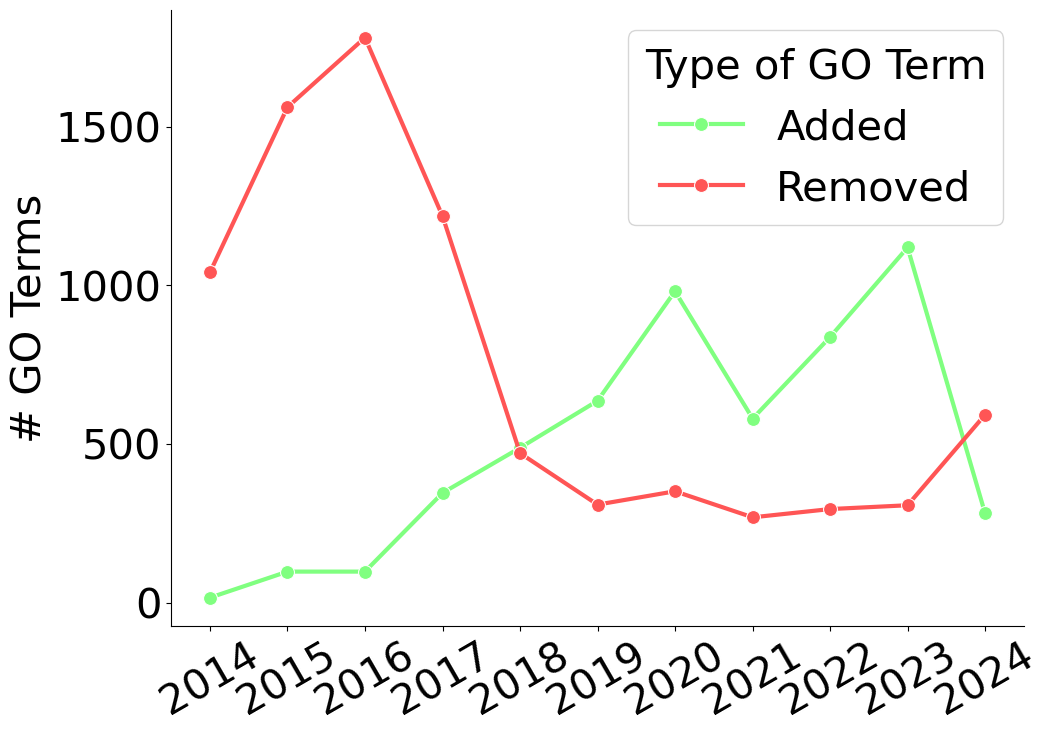

In [12]:
plt.rcParams['font.size'] = 30

df = df.iloc[1:]
fig,ax = plt.subplots(figsize=(11,8))
sns_data = df.groupby([pd.Grouper(level='dates',freq='YS')])[['new_labels','obsolete_labels']]\
    .sum()\
    .melt(ignore_index=False,
          var_name='Type of GO Term',
          value_name='# GO Terms')\
    .replace({'new_labels':'Added','obsolete_labels':'Removed'})

palette = {'Added':'#80ff80','Removed':'#ff5555'}
sns.lineplot(data = sns_data,
             x = 'dates',
             y = '# GO Terms',
             hue='Type of GO Term',
             marker='o',
             palette=palette,
             linewidth=3,
             markersize=10)
plt.xlabel('')
plt.xticks(rotation=30)
sns.despine()
plt.savefig(project_root / 'outputs' / 'figures' / 'deleted_added_go_terms.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()
